In [425]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import sort
from xgboost import XGBRegressor
from tensorflow import keras
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [447]:
import tensorflow as tf

In [3]:
data = pd.read_csv('sampled_lending_club_data.csv', parse_dates= True)

In [4]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_title', 'emp_length',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=136)

In [5]:
data['loan_status'].value_counts()

Fully Paid                                             263792
Current                                                197444
Charged Off                                             65499
Late (31-120 days)                                       4832
In Grace Period                                          1786
Late (16-30 days)                                         950
Does not meet the credit policy. Status:Fully Paid        501
Does not meet the credit policy. Status:Charged Off       177
Default                                                     9
Name: loan_status, dtype: int64

For the first question of the analysis, since we want to select 3 states based on loan's behaviour, i choose three metrics to analyze, Loan_status, Total_rec_int and delinq_2yr per state and only consider the fully paid and charged off loans.

In [549]:
df = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

In [7]:
df['loan_status'].value_counts()

Fully Paid     263792
Charged Off     65499
Name: loan_status, dtype: int64

<AxesSubplot:xlabel='loan_status', ylabel='count'>

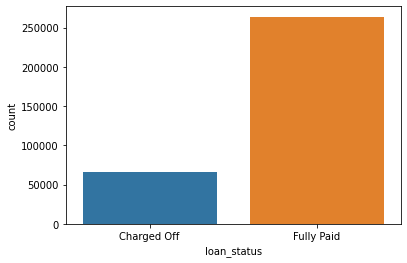

In [8]:
sns.countplot(df['loan_status'], data = df)

In [416]:
df.groupby('loan_status')['total_rec_int'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,65499.0,2699.425975,2735.471872,0.0,857.975,1809.650,3587.645,26485.64
Fully Paid,263792.0,2328.070338,2563.795996,0.0,748.820,1521.855,2901.400,28192.50


In [9]:
data['addr_state'].value_counts()

CA    75404
NY    44597
TX    44149
FL    38218
IL    21636
NJ    19938
PA    18095
GA    17718
OH    17582
VA    15080
NC    14776
MI    14049
MD    12851
AZ    12497
MA    12209
CO    11198
WA    11167
MN     9382
IN     8700
MO     8403
CT     8377
TN     8344
NV     7744
WI     7060
SC     6566
AL     6443
OR     6287
LA     6080
KY     5094
OK     4821
KS     4468
AR     3855
UT     3407
MS     2942
NM     2809
NH     2663
HI     2533
RI     2416
WV     1993
NE     1712
DE     1482
MT     1470
DC     1274
AK     1247
VT     1174
ME     1156
WY     1115
SD     1046
ID      942
ND      817
IA        4
Name: addr_state, dtype: int64

In [10]:
df.groupby(['addr_state', 'loan_status'])['loan_status'].describe()

count unique          top  freq
addr_state loan_status                                
AK         Charged Off   170      1  Charged Off   170
           Fully Paid    636      1   Fully Paid   636
AL         Charged Off   943      1  Charged Off   943
           Fully Paid   3107      1   Fully Paid  3107
AR         Charged Off   585      1  Charged Off   585
...                      ...    ...          ...   ...
WI         Fully Paid   3570      1   Fully Paid  3570
WV         Charged Off   190      1  Charged Off   190
           Fully Paid   1018      1   Fully Paid  1018
WY         Charged Off   123      1  Charged Off   123
           Fully Paid    604      1   Fully Paid   604

[101 rows x 4 columns]

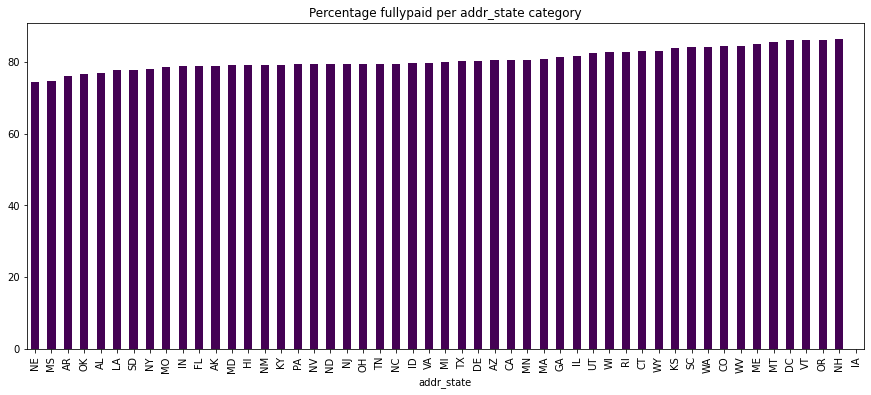

In [12]:
chargedoff = df[df.loan_status == 'Charged Off'].groupby('addr_state')['loan_status'].count()
fullypaid =  df[df.loan_status == 'Fully Paid'].groupby('addr_state')['loan_status'].count()

percentage_fullypaid = (fullypaid * 100)/(chargedoff + fullypaid)
percentage_fullypaid = percentage_fullypaid.sort_values(ascending=True)
plt.figure(figsize=(15,6))
percentage_fullypaid.plot(kind='bar', cmap='viridis')
plt.title("Percentage fullypaid per addr_state category");

clearly we can see that NH, OR and VT have the lowest percentage of charged off loans.No let's check the Total_rec_int in each State.

In [13]:
df['loss'] = df['loan_amnt'] - df['total_rec_prncp']
df['gain'] = df['total_rec_int'] - df['loss']

In [14]:
Total_rec_int = df.groupby('addr_state')['total_rec_int'].sum()
Total_rec_int = Total_rec_int.sort_values(ascending=True)


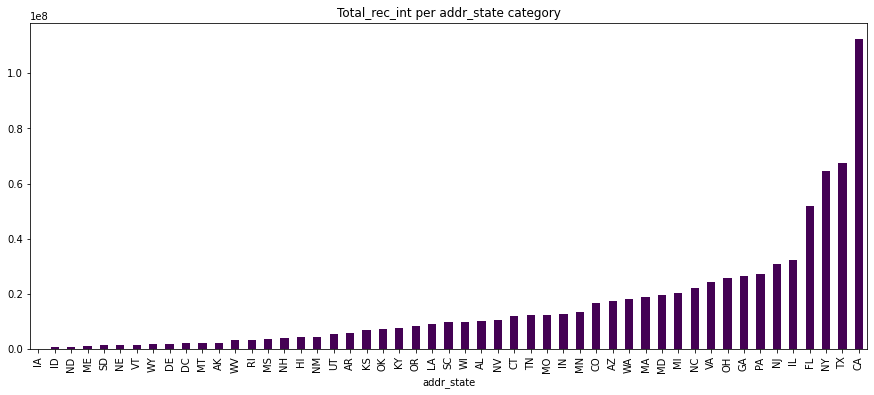

In [15]:
plt.figure(figsize=(15,6))
Total_rec_int.plot(kind='bar', cmap='viridis')
plt.title("Total_rec_int per addr_state category");

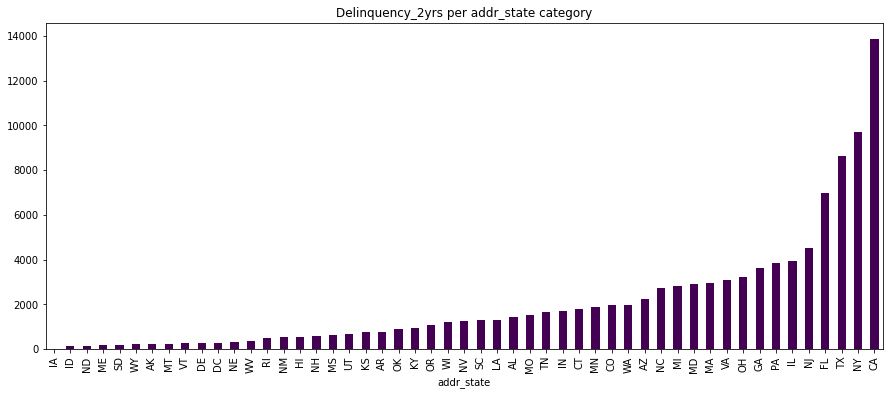

In [20]:
Delinquency_2yrs = df.groupby('addr_state')['delinq_2yrs'].sum()
Delinquency_2yrs = Delinquency_2yrs.sort_values(ascending=True)
plt.figure(figsize=(15,6))
Delinquency_2yrs.plot(kind='bar', cmap='viridis')
plt.title("Delinquency_2yrs per addr_state category");

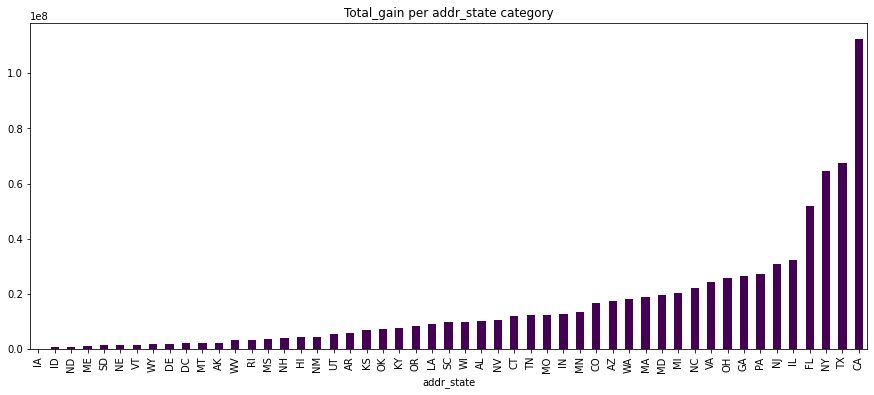

In [21]:
Total_gain = df.groupby('addr_state')['gain'].sum()
Total_gain = Total_gain.sort_values(ascending=True)
plt.figure(figsize=(15,6))
Total_rec_int.plot(kind='bar', cmap='viridis')
plt.title("Total_gain per addr_state category");

CA, TX, NY are the three states that we choose based on the higher amount of gain and lower number of charged offs.

<Figure size 1080x720 with 0 Axes>

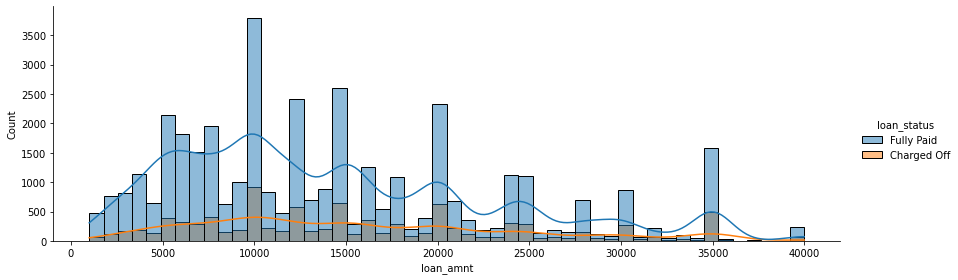

In [22]:
df1 = df[df.addr_state == 'CA']
plt.figure(figsize=(15,10))
sns.displot(data=df1, x='loan_amnt', hue='loan_status', bins=50, height=4, aspect=3, kde=True)

<Figure size 1080x720 with 0 Axes>

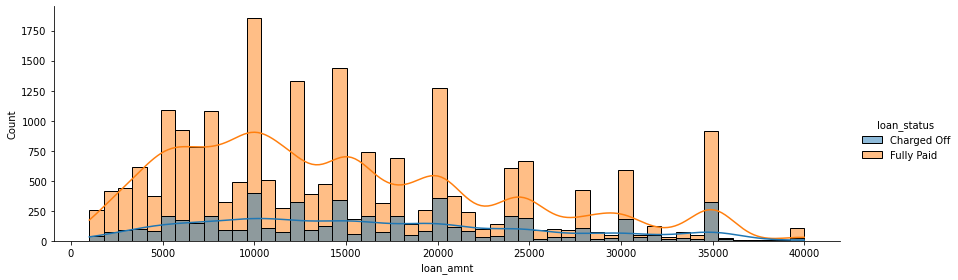

In [112]:
df2 = df[df.addr_state == 'TX']
plt.figure(figsize=(15,10))
sns.displot(data=df2, x='loan_amnt', hue='loan_status', bins=50, height=4, aspect=3, kde=True)

<Figure size 1080x720 with 0 Axes>

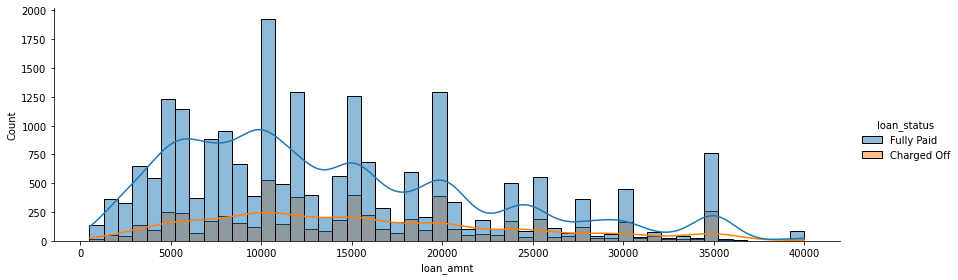

In [113]:
df3 = df[df.addr_state == 'NY']
plt.figure(figsize=(15,10))
sns.displot(data=df3, x='loan_amnt', hue='loan_status', bins=50, height=4, aspect=3, kde=True)

In [114]:
bucket_one = df1[(df1.loan_amnt > 0) & (df1.loan_amnt <10000)]
bucket_two = df1[(df1.loan_amnt > 10000) & (df1.loan_amnt <21000)]
bucket_one_int = bucket_one['total_rec_int'].sum()
bucket_one_loss = bucket_one['loss'].sum()
bucket_one_gain = bucket_one_int - bucket_one_loss 
bucket_two_int = bucket_two['total_rec_int'].sum()
bucket_two_loss = bucket_two['loss'].sum()
bucket_two_gain = bucket_two_int - bucket_two_loss 
print("bucket_one_gain_CA=%.2f" % (bucket_one_gain))
print("bucket_two_gain_CA=%.2f" % (bucket_two_gain))

bucket_one = df2[(df2.loan_amnt > 0) & (df2.loan_amnt <10000)]
bucket_two = df2[(df2.loan_amnt > 10000) & (df2.loan_amnt <21000)]
bucket_one_int = bucket_one['total_rec_int'].sum()
bucket_one_loss = bucket_one['loss'].sum()
bucket_one_gain = bucket_one_int - bucket_one_loss 
bucket_two_int = bucket_two['total_rec_int'].sum()
bucket_two_loss = bucket_two['loss'].sum()
bucket_two_gain = bucket_two_int - bucket_two_loss 
print("bucket_one_gain_TX=%.2f" % (bucket_one_gain))
print("bucket_two_gain_TX=%.2f" % (bucket_two_gain))

bucket_one = df3[(df3.loan_amnt > 0) & (df3.loan_amnt <10000)]
bucket_two = df3[(df3.loan_amnt > 10000) & (df3.loan_amnt <21000)]
bucket_one_int = bucket_one['total_rec_int'].sum()
bucket_one_loss = bucket_one['loss'].sum()
bucket_one_gain = bucket_one_int - bucket_one_loss 
bucket_two_int = bucket_two['total_rec_int'].sum()
bucket_two_loss = bucket_two['loss'].sum()
bucket_two_gain = bucket_two_int - bucket_two_loss 
print("bucket_one_gain_NY=%.2f" % (bucket_one_gain))
print("bucket_two_gain_NY=%.2f" % (bucket_two_gain))

bucket_one_gain_CA=3335944.12
bucket_two_gain_CA=2251795.00
bucket_one_gain_TX=1676918.51
bucket_two_gain_TX=2427349.36
bucket_one_gain_NY=1763413.90
bucket_two_gain_NY=-335787.83


In CA we should target bucket one, in TX we should target bucket two and in NY we should target bucket one!

In [105]:
df3['gain']

KeyError: 'gain'

In [121]:
df.isnull().sum()/len(df) * 100

id                         0.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_amount         97.502817
settlement_percentage     97.502817
settlement_term           97.502817
loss                       0.000000
gain                       0.000000
Length: 138, dtype: float64

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137]),
 [Text(0, 0, 'id'),
  Text(1, 0, 'revol_bal'),
  Text(2, 0, 'total_acc'),
  Text(3, 0, 'initial_list_status'),
  Text(4, 0, 'out_prncp'),
  Text(5, 0, 'out_prncp_inv'),
  Text(6, 0, 'total_pymnt'),
  Text(7, 0, 'total_py

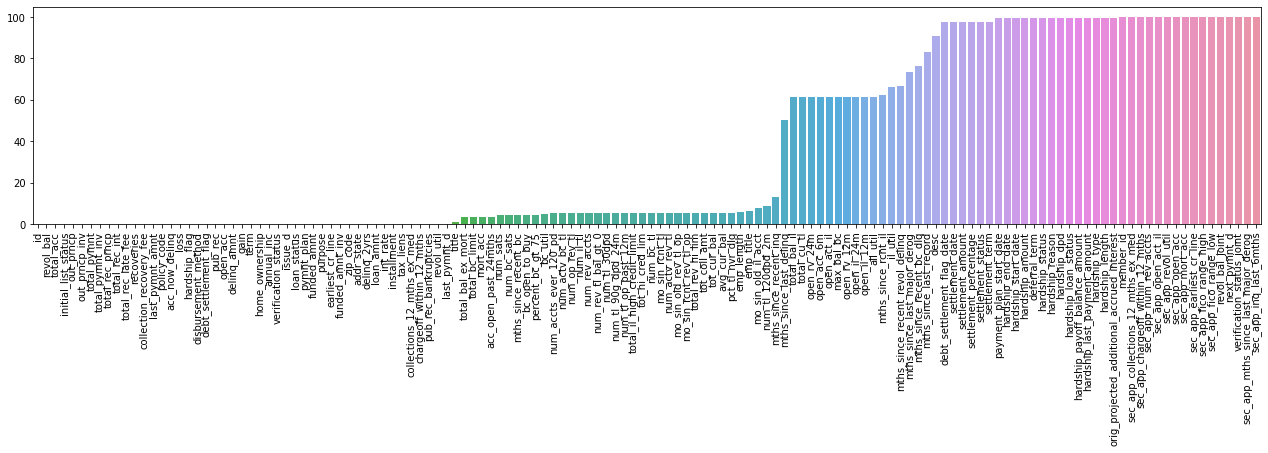

In [123]:
plt.figure(figsize=(22,4))
sns.barplot(x=((df.isnull().sum()/len(df))*100).sort_values().index,y=((df.isnull().sum()/len(df))*100).sort_values()) 
plt.xticks(rotation=90)

In [550]:
col = df.columns[((df.isnull().sum()/len(df))*100 < 40)].to_list()
df = df[col]

In [551]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_

In [552]:
features = ['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length', 'emp_title', 'home_ownership',
                    'initial_list_status', 'int_rate', 'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
                    'purpose', 'revol_bal', 'revol_util', 'term', 'title', 'total_acc', 'verification_status','pymnt_plan','loan_status','total_rec_int','delinq_2yrs']

In [553]:
df = df[features]

In [554]:
df.dtypes

addr_state               object
annual_inc              float64
earliest_cr_line         object
emp_length               object
emp_title                object
home_ownership           object
initial_list_status      object
int_rate                float64
loan_amnt               float64
num_actv_bc_tl          float64
mort_acc                float64
tot_cur_bal             float64
open_acc                float64
pub_rec                 float64
pub_rec_bankruptcies    float64
purpose                  object
revol_bal               float64
revol_util              float64
term                     object
title                    object
total_acc               float64
verification_status      object
pymnt_plan               object
loan_status              object
total_rec_int           float64
delinq_2yrs             float64
dtype: object

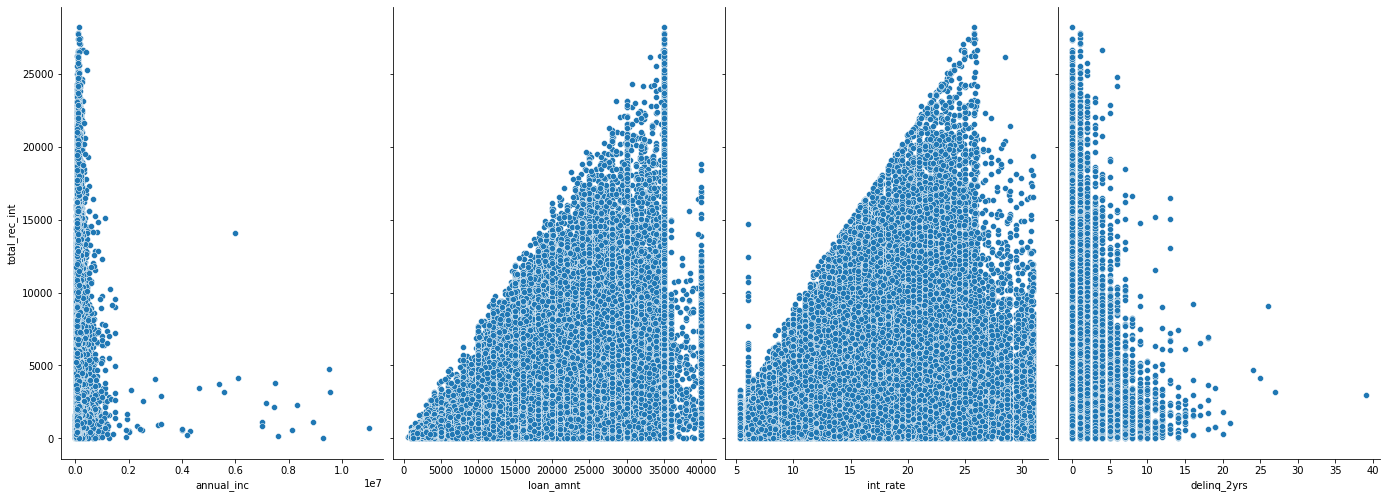

In [555]:
sns.pairplot(df , x_vars=['annual_inc', 'loan_amnt', 'int_rate','delinq_2yrs'] , y_vars= 'total_rec_int', size= 7, aspect=0.7)

In [556]:
state_dummies = pd.get_dummies(df['addr_state'], drop_first=True)
df = pd.concat([df.drop('addr_state', axis=1), state_dummies], axis=1)

count      329291.000000
mean        76824.084969
std         79740.284051
min          3092.000000
25%         46000.000000
50%         65000.000000
75%         91000.000000
max      10999200.000000
Name: annual_inc, dtype: object

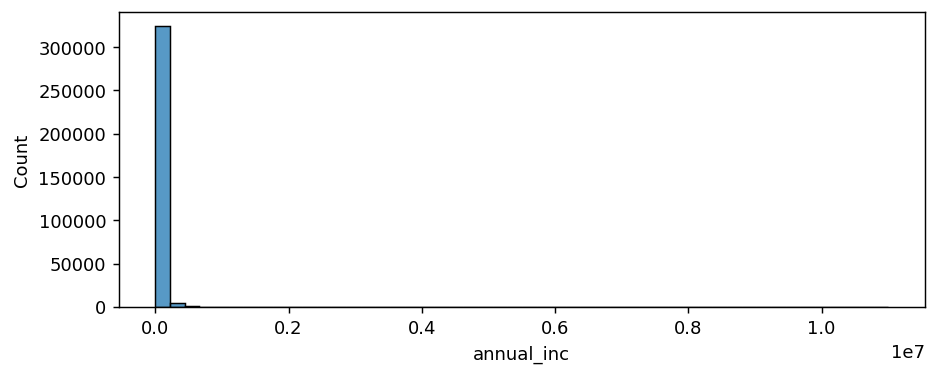

In [557]:
plt.figure(figsize=(8,3), dpi=130)
sns.histplot(x=df['annual_inc'], bins = 50)
df['annual_inc'].describe().apply(lambda x: format(x, 'f'))

In [558]:
df = df[df['annual_inc'] <= 160000]

In [559]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: int(x[-4:]))

<AxesSubplot:xlabel='emp_length', ylabel='count'>

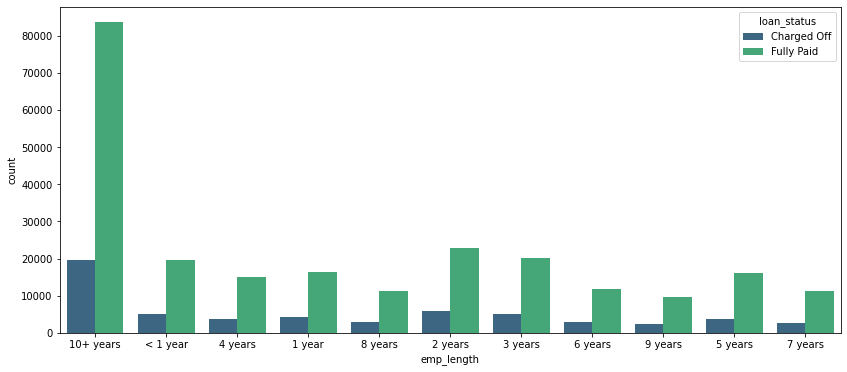

In [560]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=df,hue='loan_status', palette='viridis')

In [561]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']
percentage= (charged_off * 100)/(charged_off + fully_paid)
percentage

emp_length
1 year       20.833132
10+ years    19.071411
2 years      20.238839
3 years      20.130719
4 years      19.991459
5 years      19.198344
6 years      19.761407
7 years      19.764181
8 years      20.124991
9 years      19.885010
< 1 year     20.414575
Name: loan_status, dtype: float64

In [562]:
df = df.drop('emp_length', axis=1)
df = df.drop('emp_title', axis=1)

In [563]:
df['home_ownership'].value_counts()

MORTGAGE    151621
RENT        129060
OWN          33841
ANY             63
OTHER           32
NONE             6
Name: home_ownership, dtype: int64

In [564]:
df['home_ownership'] = df['home_ownership'].replace(['ANY', 'NONE'], 'OTHER')

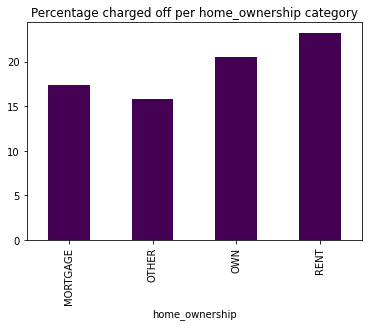

In [565]:
chargedoff = df[df.loan_status == 'Charged Off'].groupby('home_ownership')['loan_status'].count()
fullypaid =  df[df.loan_status == 'Fully Paid'].groupby('home_ownership')['loan_status'].count()
percentage_charged_off = (chargedoff * 100)/(chargedoff + fullypaid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per home_ownership category");

In [566]:
dummies_home_ownership = pd.get_dummies(df['home_ownership'], drop_first=True)
df = pd.concat([df.drop('home_ownership', axis=1), dummies_home_ownership], axis=1)

In [567]:
df['initial_list_status'].value_counts()

w    181217
f    133406
Name: initial_list_status, dtype: int64

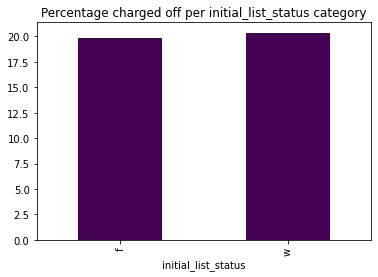

In [568]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("initial_list_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("initial_list_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per initial_list_status category");

In [569]:
df = df.drop('initial_list_status', axis=1)

In [570]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,63315.0,15.719022,4.852750,5.31,12.35,15.05,18.55,30.99
Fully Paid,251308.0,12.652295,4.492451,5.31,9.17,12.29,15.31,30.99


In [571]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,63315.0,15158.069178,8530.881439,1000.0,8700.0,14000.0,20000.0,40000.0
Fully Paid,251308.0,13572.969026,8261.753083,500.0,7200.0,12000.0,18725.0,40000.0


In [572]:
df['num_actv_bc_tl'].isna().value_counts()

False    298330
True      16293
Name: num_actv_bc_tl, dtype: int64

In [573]:
df['num_actv_bc_tl'].describe()

count    298330.000000
mean          3.620618
std           2.218677
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          35.000000
Name: num_actv_bc_tl, dtype: float64

In [574]:
df['num_actv_bc_tl'] = df['num_actv_bc_tl'].fillna(4)

In [575]:
df = df[df['num_actv_bc_tl'] < 10]

In [576]:
df.groupby('loan_status')['num_actv_bc_tl'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,61769.0,3.620441,1.930464,0.0,2.0,3.0,5.0,9.0
Fully Paid,247006.0,3.458426,1.847258,0.0,2.0,3.0,4.0,9.0


In [577]:
df['mort_acc'].describe().apply(lambda x: format(x, 'f'))

count    297397.000000
mean          1.593143
std           1.938465
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          29.000000
Name: mort_acc, dtype: object

In [578]:
df['mort_acc'] = df['mort_acc'].fillna(2)
df = df[df['mort_acc'] < 8]
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,61281.0,1.279189,1.618222,0.0,0.0,1.0,2.0,7.0
Fully Paid,244011.0,1.583187,1.743721,0.0,0.0,1.0,3.0,7.0


In [579]:
df['total_acc'].describe().apply(lambda x: format(x, 'f'))

count    305292.000000
mean         24.315704
std          11.617229
min           2.000000
25%          16.000000
50%          23.000000
75%          31.000000
max         156.000000
Name: total_acc, dtype: object

In [580]:
df = df[df['total_acc'] < 54]
df.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,59996.0,23.317121,10.425804,2.0,15.0,22.0,30.0,53.0
Fully Paid,239257.0,23.629637,10.381333,2.0,16.0,22.0,30.0,53.0


In [581]:
df = df.drop('total_acc', axis=1)

In [582]:
df['tot_cur_bal'].describe().apply(lambda x: format(x, 'f'))

count     283231.000000
mean      123563.087649
std       127920.975687
min            0.000000
25%        27485.000000
50%        69248.000000
75%       190389.000000
max      1563589.000000
Name: tot_cur_bal, dtype: object

In [583]:
df['tot_cur_bal'].isna().value_counts()

False    283231
True      16022
Name: tot_cur_bal, dtype: int64

<AxesSubplot:xlabel='tot_cur_bal', ylabel='Count'>

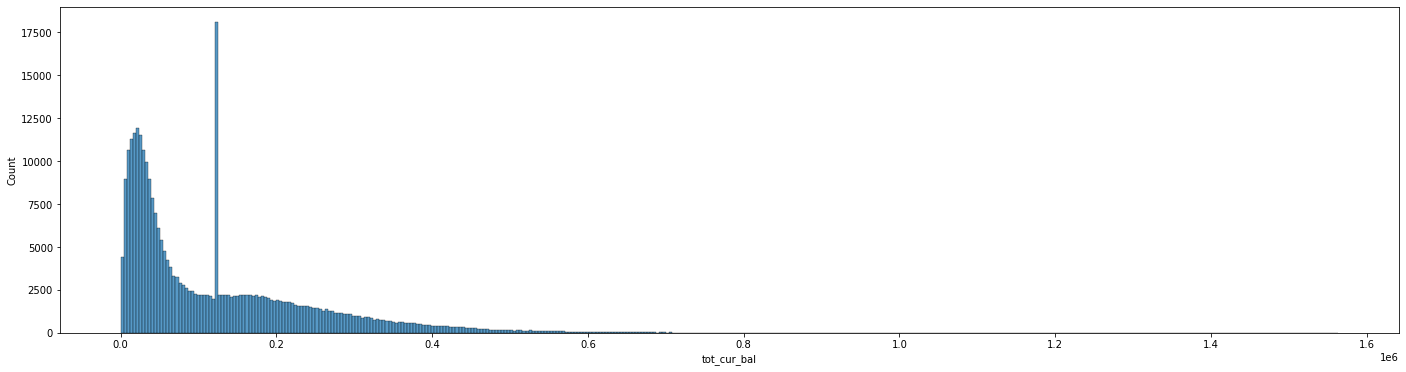

In [584]:
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean())
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='tot_cur_bal', bins=400, palette='viridis')

<AxesSubplot:xlabel='tot_cur_bal'>

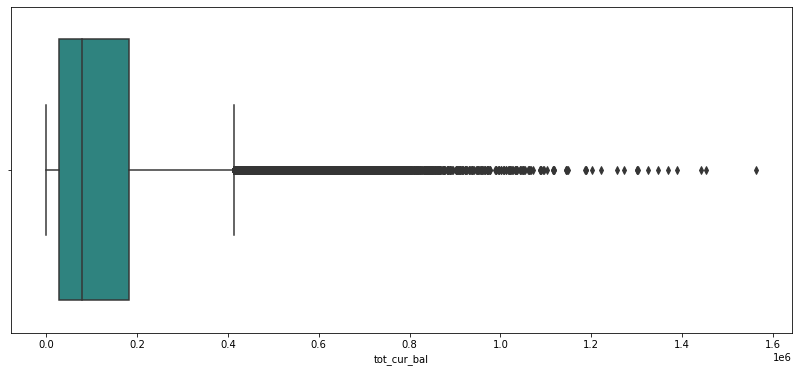

In [585]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='tot_cur_bal', palette='viridis')

In [586]:
df = df[df['tot_cur_bal'] < 450000]
df.groupby('loan_status')['tot_cur_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,59062.0,100479.121266,98116.161086,0.0,26737.0,58494.5,146800.75,449846.0
Fully Paid,233301.0,116636.039383,106543.496652,0.0,28800.0,81034.0,179496.00,449970.0


In [587]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,59062.0,11.292083,4.947968,0.0,8.0,11.0,14.0,49.0
Fully Paid,233301.0,10.938479,4.790435,0.0,7.0,10.0,14.0,42.0


In [588]:
df = df.drop('open_acc', axis=1)

In [589]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,59062.0,0.250076,0.674331,0.0,0.0,0.0,0.0,61.0
Fully Paid,233301.0,0.210612,0.585045,0.0,0.0,0.0,0.0,63.0


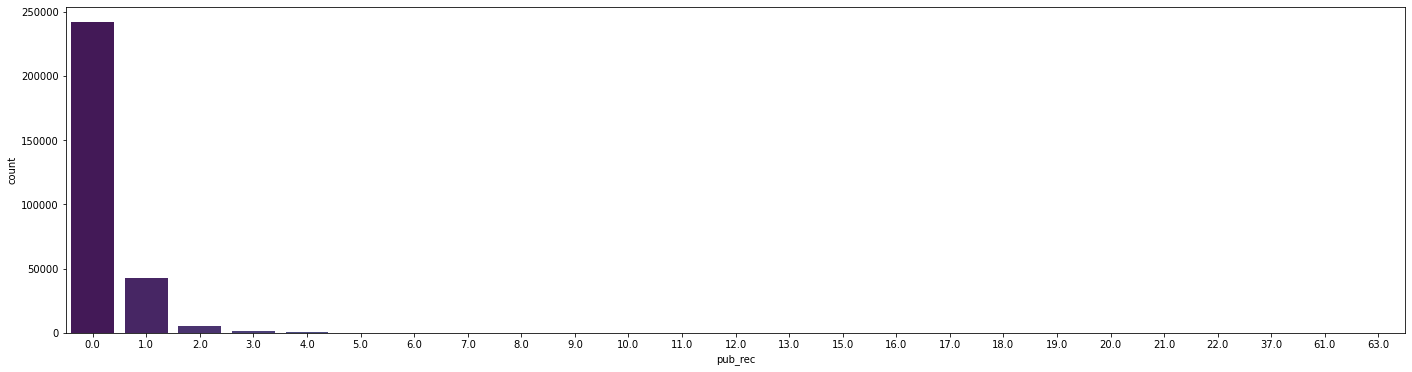

In [590]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='pub_rec', palette='viridis');

In [591]:
df = df[df['pub_rec'] < 2]

In [592]:
df['pub_rec_bankruptcies'].isna().sum()

168

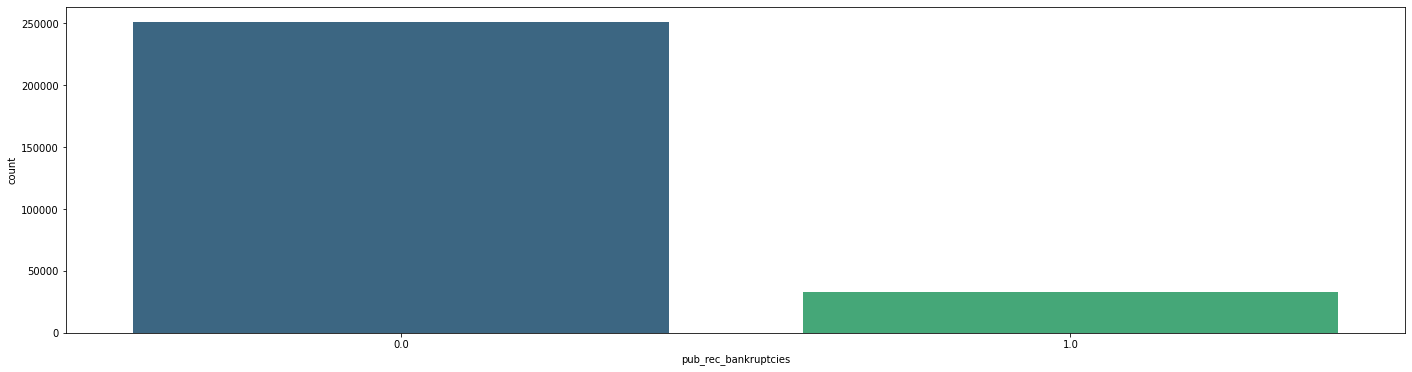

In [593]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='pub_rec_bankruptcies', palette='viridis');

In [594]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [595]:
df.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,57148.0,0.131763,0.338236,0.0,0.0,0.0,0.0,1.0
Fully Paid,227126.0,0.113157,0.316786,0.0,0.0,0.0,0.0,1.0


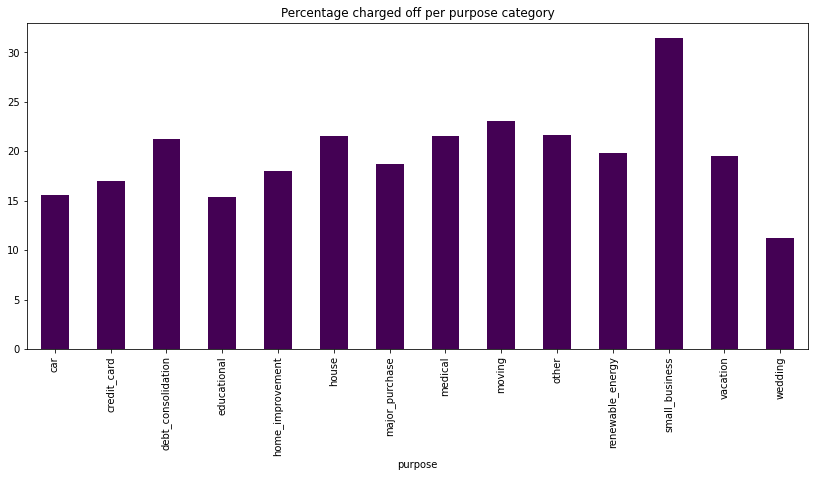

In [596]:
plt.figure(figsize=(14,6))
charged_off = df[df['loan_status']=="Charged Off"].groupby("purpose").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("purpose").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per purpose category");

In [597]:
dummies_purpose = pd.get_dummies(df['purpose'], drop_first=True)
df = pd.concat([df.drop('purpose', axis=1), dummies_purpose], axis=1)

In [598]:
df.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,57148.0,13814.243508,13524.315572,0.0,5839.0,10603.5,17814.0,403502.0
Fully Paid,227126.0,14120.107632,14309.703218,0.0,5713.0,10511.0,18086.0,428156.0


In [599]:
df['revol_util'].isna().sum()

159

In [600]:
df['revol_util'].describe().apply(lambda x: format(x, 'f'))

count    284115.000000
mean         51.965824
std          24.470007
min           0.000000
25%          33.700000
50%          52.300000
75%          70.900000
max         177.700000
Name: revol_util, dtype: object

In [601]:
df = df[df['revol_util'] < 130]

In [602]:
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

In [603]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,57110.0,54.955593,23.881151,0.0,37.6,55.7,73.4,127.6
Fully Paid,226993.0,51.208417,24.548569,0.0,32.7,51.4,70.2,128.6


<AxesSubplot:xlabel='revol_util'>

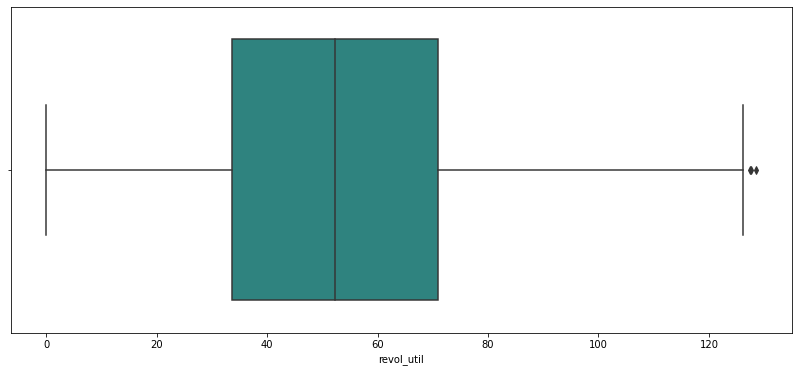

In [604]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='revol_util', palette='viridis')

In [605]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

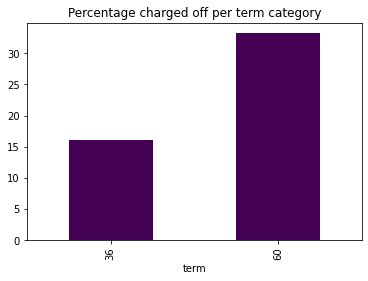

In [606]:
df['term'] = df['term'].apply(lambda x: int(x[0:3]))
charged_off = df[df['loan_status']=="Charged Off"].groupby("term").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("term").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per term category");

In [607]:
dummies_term = pd.get_dummies(df['term'], drop_first=True)
df = pd.concat([df.drop('term', axis=1), dummies_term], axis=1)

In [608]:
df['title'].unique()

array(['Credit card refinancing', 'Other', 'Debt consolidation', ...,
       'Region 12 education', "All paid, it's all paid!",
       'Spring Debt Consolidation'], dtype=object)

In [609]:
df = df.drop('title', axis=1)

In [610]:
df['verification_status'].value_counts()

Source Verified    108925
Not Verified        89509
Verified            85669
Name: verification_status, dtype: int64

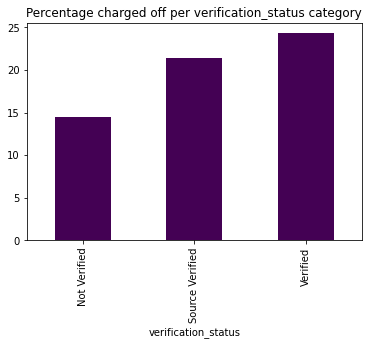

In [611]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("verification_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("verification_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
percentage_charged_off.plot(kind='bar', cmap='viridis')
plt.title("Percentage charged off per verification_status category");

In [612]:
dummies = pd.get_dummies(df['verification_status'], drop_first=True)
df = pd.concat([df.drop('verification_status', axis = 1), dummies], axis = 1)

In [613]:
df['pymnt_plan'].value_counts()

n    284103
Name: pymnt_plan, dtype: int64

In [614]:
df = df.drop('pymnt_plan', axis=1)

In [615]:
df['delinq_2yrs'].isna().sum()

0

In [616]:
df.groupby('loan_status')['delinq_2yrs'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,57110.0,0.342795,0.911943,0.0,0.0,0.0,0.0,27.0
Fully Paid,226993.0,0.298203,0.836782,0.0,0.0,0.0,0.0,39.0


In [617]:
df['delinq_2yrs'].describe()

count    284103.000000
mean          0.307167
std           0.852609
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: delinq_2yrs, dtype: float64

In [618]:
df = df.drop('loan_status', axis=1)

In [619]:
df.shape 

(284103, 82)

In [620]:
sum(df.isnull().any())

0

In [621]:
df['total_rec_int'].describe()

count    284103.000000
mean       2310.246119
std        2518.163781
min           0.000000
25%         743.865000
50%        1511.980000
75%        2896.555000
max       28192.500000
Name: total_rec_int, dtype: float64

<AxesSubplot:xlabel='total_rec_int'>

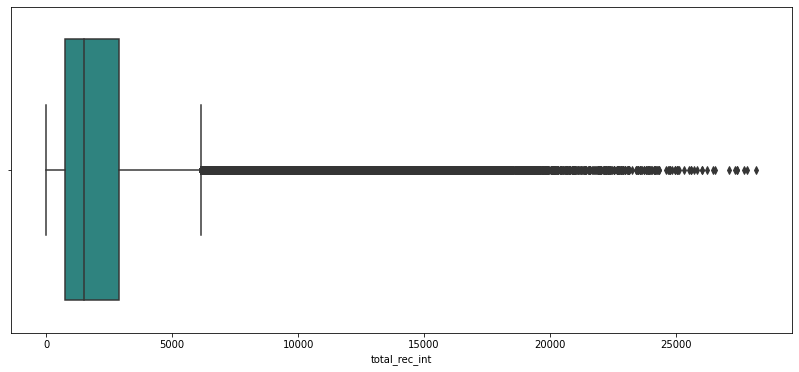

In [622]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='total_rec_int', palette='viridis')

In [623]:
df = df[df['total_rec_int'] < 6500]

In [624]:
df.shape

(265460, 82)

In [625]:

X = df.drop(['total_rec_int'], axis = 1)
# X = data[['DIVISION', 'REGIONC','TYPEHUQ','NWEIGHT','HDD30YR']]
Y = df['total_rec_int']
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model on all training data
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = metrics.mean_absolute_error(y_test, predictions)
# Fit model using each importance as a threshold
thresholds = sorted(model.feature_importances_, reverse=True)
for thresh in thresholds:
    if thresh > 0:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBRegressor(objective='reg:squarederror')
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = metrics.mean_absolute_error(y_test, predictions)
        print("Thresh=%.12f, n=%d, MAE: %.2f" % (thresh, select_X_train.shape[1], accuracy))

Thresh=0.273609131575, n=1, MAE: 786.17
Thresh=0.076041981578, n=2, MAE: 628.64
Thresh=0.059441536665, n=3, MAE: 628.02
Thresh=0.030942821875, n=4, MAE: 628.27
Thresh=0.024857454002, n=5, MAE: 626.32
Thresh=0.016561523080, n=6, MAE: 627.91
Thresh=0.015342565253, n=7, MAE: 627.84
Thresh=0.014274684712, n=8, MAE: 626.45
Thresh=0.011797741987, n=9, MAE: 627.67
Thresh=0.011041232385, n=10, MAE: 627.38
Thresh=0.010670193471, n=11, MAE: 628.05
Thresh=0.010624557734, n=12, MAE: 627.74
Thresh=0.009803009219, n=13, MAE: 628.27
Thresh=0.009771947749, n=14, MAE: 628.01
Thresh=0.009627823718, n=15, MAE: 627.14
Thresh=0.009488360956, n=16, MAE: 626.71
Thresh=0.009469110519, n=17, MAE: 627.84
Thresh=0.009336598217, n=18, MAE: 628.04
Thresh=0.009307054803, n=19, MAE: 627.78
Thresh=0.009069176391, n=20, MAE: 627.25
Thresh=0.009036735632, n=21, MAE: 631.85
Thresh=0.008860745467, n=22, MAE: 629.16
Thresh=0.008812079206, n=23, MAE: 629.90
Thresh=0.008653870784, n=24, MAE: 629.19
Thresh=0.008552006446, n=

In [626]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feat_imp_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
feat_imp_df

,score
loan_amnt,334036864.0
int_rate,92836176.0
60,72569456.0
Verified,37776676.0
revol_util,30347330.0
...,...
renewable_energy,5064142.0
AR,4841442.0
MA,4553024.0
NM,3069289.0


In [627]:
selection = SelectFromModel(model, threshold=0.009069176391, prefit=True)
select_X_train = selection.transform(X_train)

In [628]:
xgb_reg = xgb.XGBRegressor()
params = {
    'n_estimators': [150,160],
    'learning_rate':[.2996,.3,.2995]
}

Gsv = GridSearchCV(estimator=xgb_reg, param_grid=params, cv=3)

Gsv.fit(select_X_train, y_train)
# predic = Gsv.predict(x_test)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [629]:
Gsv.best_params_

{'learning_rate': 0.2995, 'n_estimators': 150}

In [630]:
select_X_test = selection.transform(X_test)
y_pred = Gsv.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = metrics.mean_absolute_error(y_test, predictions)
print("n=%d, Accuracy: %.2f" % ( select_X_train.shape[1], accuracy))

n=20, Accuracy: 625.56


In [631]:
from pygam import LinearGAM
gam = LinearGAM(n_splines=30).gridsearch(select_X_train, y_train.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:05:16 Time:  0:05:16


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    133.1693
Link Function:                     IdentityLink Log Likelihood:                              -3126420.2383
Number of Samples:                       212368 AIC:                                          6253108.8152
                                                AICc:                                         6253108.9861
                                                GCV:                                           988457.1569
                                                Scale:                                         987341.5243
                                                Pseudo R-Squared:                                   0.5289
Feature Function                  Lam

In [201]:
gam.predict(select_X_test)

array([1186.17202708, 3150.83870742, 3520.09987304, ..., 2934.22471201,
       5010.25377511, 3334.85833644])

In [632]:
accuracy = metrics.mean_absolute_error(y_test, gam.predict(select_X_test))

In [633]:
accuracy

698.3846106189803

In [457]:
select_X_train.shape

(229362, 36)

In [455]:
LOSS = 'mse'  
MODEL = 'dnn' 
LEARNING_RATE = 0.0002
EPOCHS = 400